# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  


In [1]:
#Changing directory to the github home folder /Ctherm_thermo
import os
os.chdir('/Users/satyakam/Dropbox/work/equilibrator-api-master')
import sys
sys.path.append('/Users/satyakam/Dropbox/work/sbtab-0.9.64')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src/equilibrator_api')
sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src')
#sys.path.append('/Users/satyakam/Dropbox/work')


In [2]:
import numpy as np
from numpy import array, eye, log, zeros, matrix
from numpy.linalg import inv, solve
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [3]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to long name
ktn = kt.loc[:,['KEGG ID(S)', 'PRIMARY NAME']]
ktn['KEGG ID(S)'] = ktn['KEGG ID(S)'].str.lower() # set to lower case for better matching
ktn.set_index('KEGG ID(S)', inplace = True)

# translate long name to KEGG ID
# the original dictionaries sometimes had trouble with duplicate KEGG IDs. If there are duplicates, make sure to choose the lowest number
ntk = kt.loc[:,['PRIMARY NAME', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
ntk['PRIMARY NAME'] = ntk['PRIMARY NAME'].str.lower() # set to lower case for better matching
ntk = ntk.groupby('PRIMARY NAME').first() # take the first KEGG ID in each group

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']]
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk.set_index('ABBREVIATION', inplace = True)

atkDict = dict(zip(atk.index, atk['KEGG ID(S)'].str.upper()))
ktaDict = dict(zip(kta.index.str.upper(), kta['ABBREVIATION'].values))

## Set up model
* Choose reactions
* Set fluxes
* Set concentration bounds
* Set pH and ionic strength

In [4]:
os.chdir('/Users/satyakam/Dropbox/work/component_contribution_ctherm')

In [145]:
allRxnDf = pd.read_excel('all_ems_and_ham_dist_DO_SD.xlsx', sheet_name = 'EFM_model_input')
allRxnDf[:2]

,Name,AbbreviationFormula,KeggFormula,1,2,3,4,5,6,7,...,327,328,329,330,331,332,333,334,335,336
ATPase1,ATP + H2O <=> ADP + Pi,h2o + atp <=> adp + pi,C00002 + C00001 <=> C00008 + C00009,1,1,4,1,1,5,2,...,6,5,6,5,5,6,5,5,5,5
CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,1,1,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1


In [195]:
# choose a flux set, and drop all of the zero-flux reactions
# loop over fluxsets to generate multiple models 
selectedRxnDf={}
no_EFM=len(allRxnDf.columns)-3 # no of EFMs
for f in range(1,no_EFM+1):
    selectedRxnDf[f] = allRxnDf.loc[allRxnDf[f] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', f]]
    selectedRxnDf[f].rename(columns = {f:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent

selectedRxnDf[1]['flux']['ATPase1'] # EFM:227 corresponds to wild-type with 6 ATP generated (2 from ATPase1, 4 from ATPase2)
allRxnDf.loc['ME']['AbbreviationFormula']

ATPase1       1
CBP           1
BGL           0
GLK-GTP       0
GLK-ATP       1
PGMT          1
PGI           2
PFK-PPi       0
PFK-ATP       2
FBA           2
TPI           2
GAPDH         0
GAPN          4
PGK-ATP       0
PGK-GTP       0
PGM           4
ENO           4
PYK           4
PPDK          0
PEPCK         0
MDH           0
ME            0
PFOR          0
RNF_ATPase    0
RNF_PPiase    0
NFN           0
PDC           4
ALDH-NADH     0
ALDH-NADPH    0
ADH-NADH      0
ADH-NADPH     4
Bifur_Hyd     0
NDK           0
Gly-cyc       0
NADPH-FNOR    0
NADH-FNOR     0
ATPase2       0
Name: 1, dtype: int64

In [159]:
#Import metabolite bound data from excel file
Met_data = pd.read_excel('cth_thermo_model_DO_SD6.xlsx', sheet_name = 'metabolite_bounds')
Met_data

,KEGG_ID,Name,Concentration:Max,Concentration:Min,Type,GetFromMeasured,Unnamed: 6,max (µM),min (µM)
0,C00008,adp,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
1,C00020,amp,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
2,C00002,atp,0.02000,0.001000,Cofactor,no,NaN,20000.0,1000.0
3,C00010,coa,0.02000,0.000001,Cofactor,no,NaN,20000.0,1.0
4,C00139,fdxox,0.00010,0.000100,Cofactor,NaN,NaN,100.0,100.0
5,C00138,fdxrd,0.01000,0.000001,Cofactor,NaN,NaN,10000.0,1.0
6,C00035,gdp,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
7,C00044,gtp,0.02000,0.001000,Cofactor,no,NaN,20000.0,1000.0
8,C00003,nad,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
9,C00004,nadh,0.01000,0.000001,Cofactor,no,NaN,10000.0,1.0


In [204]:
Uf = 1 # Uncertainity factor
all_data={}
for f in range(1,no_EFM+1):
    reactions = []
    for i, row in selectedRxnDf[f].iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
    # create flux list
    fluxes = selectedRxnDf[f]['flux'].values

    # need to declare pH and ionic strength constants at the beginning
    PH = 7.0
    IS = 0.1

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)    
    all_data[f] = {}
    
    #impose default concentration bounds read from excel file
    for i, cpd in Met_data.iterrows():
        pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
    pp.bounds.SetBounds('C00011',0.00001,0.001 )
           
    # calculate the min-max driving force
    mdf_data, con = pp.conc_mdf()
    #mdf_data.mdf_plot
    # store the data
    all_data[f]['mdf'] = mdf_data
    all_data[f]['con'] = con

In [205]:
import matplotlib.pyplot as plt
all_mdf={}
for f in range(1,no_EFM+1):
    all_mdf[f]=float(all_data[f]['mdf'].mdf)
df1 = pd.DataFrame.from_dict(list(all_mdf.items()))    
all_atp={}   
for f in range(1,no_EFM+1):
    try:
        all_atp[f]=selectedRxnDf[f]['flux']['ATPase1']+selectedRxnDf[f]['flux']['ATPase2'] # assuming all ATP generated are being consumed by ATPase 1 and 2, 1st reaction, have to check this
    except:
        try:
            all_atp[f]=selectedRxnDf[f]['flux']['ATPase1']
        except:
            try:
                all_atp[f]=selectedRxnDf[f]['flux']['ATPase2']
            except:
                all_atp[f]=0
                print(f)
            
df2 = pd.DataFrame.from_dict(list(all_atp.items()))         

#plt.scatter(df1[1],df2[1])
#plt.xlabel('MDF of flux set')
#plt.ylabel('ATP generated by fluxset')
#plt.title('MDF vs ATP generated')

In [206]:
#Hamming distance calculation
df=pd.DataFrame(index=np.arange(1, no_EFM),columns=('mdf', 'atp', 'ham'))
ham_dis={}
wt_ind=227
for f in range(1,no_EFM+1):
    inx=0
    ham_dis[f]=0

    for i in allRxnDf[[f]][f]:
        #calculating hamming distance by counting the unique reactions in the larger EFM 
        if not ((i == 0 and allRxnDf[[wt_ind]][wt_ind][inx] == 0) or (abs(i)>0 and abs(allRxnDf[[wt_ind]][wt_ind][inx])>0)):
            if len(selectedRxnDf[inx+1])>len(selectedRxnDf[wt_ind]):
                ham_dis[f]+=np.sign(abs(i))
            else:
                ham_dis[f]+=np.sign(abs(allRxnDf[[wt_ind]][wt_ind][inx]))
        inx+=1
    df.loc[f]=[df1[1][f-1],df2[1][f-1],ham_dis[f]]

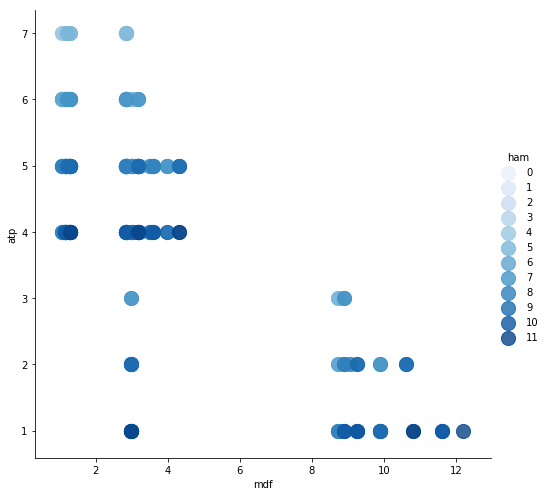

In [207]:
#max(ham_dis)
import seaborn as sns
color = [str((item*10)/(max(ham_dis)*10)) for item in ham_dis]


#ax.scatter(df1[1],df2[1],c=color,s=300, marker='o', edgecolors='black')



#plt.xlabel('MDF of flux set')
#plt.ylabel('ATP generated by fluxset')
#plt.title('MDF vs ATP generated')
# library & dataset
#df3 = pd.DataFrame.from_dict(list(ham_dis.items()))   

#df=pd.merge(df1,df2,0.df1,0.df2)
# Use the 'hue' argument to provide a factor variable

sns_plot=sns.lmplot( x='mdf', y='atp', data= df ,fit_reg=False, hue='ham', palette="Blues", legend=True, height=7, markers='o',scatter_kws={"s": 200})
sns_plot.savefig("mdfvsatp.png")

In [208]:
#write the mdf, hamming distance, and atp generated into a csv file
import csv
w = csv.writer(open("output_v3_co2.csv", "w"))
for key, val in all_mdf.items():
    w.writerow([key, val,all_atp[key],ham_dis[key]])
all_data[1]['con'].items()   
w = csv.writer(open("output_conc_v3_co2.csv", "w"))
for f in range(1,no_EFM+1):
    k=0
    for c in all_data[f]['mdf'].compound_data:
        w.writerow([f,ktaDict[c.compound], all_data[f]['con'][k]])
        k=k+1
    w.writerow(" ")

In [165]:
chk_data={}
for f in range(227,228):
    reactions = []
    for i, row in selectedRxnDf[f].iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
    # create flux list
    fluxes = selectedRxnDf[f]['flux'].values

    # need to declare pH and ionic strength constants at the beginning
    PH = 7.0
    IS = 0.1

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)    
    chk_data[f] = {}
    
    #impose default concentration bounds read from excel file
    for i, cpd in Met_data.iterrows():
        pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
        #print(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'])
        #pp.bounds.SetBounds(cpd['KEGG_ID'],1e-6,1e-2 )
    #pp.bounds.SetBounds('C00469',1e-6,1e-2)      
    # calculate the min-max driving force
    mdf_data, con = pp.conc_mdf()
    #mdf_data.mdf_plot
    # store the data
    chk_data[f]['mdf'] = mdf_data
    chk_data[f]['con'] = con
for r in mdf_data.reaction_data:
    print(r.reaction.reaction_id, float(r.dGr))

ATP + H2O <=> ADP + Pi -43.507631032369446
Phosphate + Cellobiose <=> D-Glucose + Glucose-1-phosphate  -2.8291089397399487
D-Glucose + GTP <=> D-Glucose-6-phosphate + GDP -20.492743350376244
Glucose-1-phosphate <=> D-glucose-6-phosphate  -2.8291089397399523
D-Glucose-6-phosphate <=> D-Fructose-6-phosphate -2.8291089397399496
PPi + D-fructose-6-phosphate <=> Phosphate + D-Fructose-1,6-bisphosphate + H+  -2.829108939739945
D-Fructose-1,6-bisphosphate <=> Glycerone-phosphate + D-Glyceraldehyde-3-phosphate -2.8291089397399602
Glycerone-phosphate <=> D-Glyceraldehyde-3-phosphate -2.8291089397399496
Phosphate + NAD + D-Glyceraldehyde-3-phosphate <=> NADH + 1,3-Bisphosphoglycerate -2.829108939739948
GDP + 1,3-Bisphosphoglycerate <=> GTP + D-Glycerate-3-phosphate -2.8291089397399602
D-Glycerate-3-phosphate <=> D-Glycerate-2-phosphate -2.829108939739947
D-Glycerate-2-phosphate <=> Phosphoenolpyruvate + H2O -2.829108939739956
AMP + PPi + Phosphoenolpyruvate <=> ATP + Phosphate + Pyruvate + H+ -2

In [166]:
k=0
print(chk_data[227]['mdf'].mdf)
for c in all_data[227]['mdf'].compound_data:
        print([f,ktaDict[c.compound], chk_data[227]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound),chk_data[227]['con'][k], c.shadow_price])
        k=k+1

2.8291089397399496
[227, 'h2o', (1.0, 1.0), (1.0, 1.0), 3.6859621022067295e-16]
[227, 'atp', (0.001, 0.02), (0.001000000000000001, 0.0010169411996443696), 0.0]
[227, 'nad', (0.0001, 0.0001), (0.00010000000000000009, 0.00010000000000000009), 0.0]
[227, 'nadh', (1e-06, 0.01), (2.4780095370124383e-06, 2.4780095370124336e-06), 0.0]
[227, 'adp', (0.0001, 0.0001), (9.999999999999991e-05, 9.999999999999991e-05), 3.2354747262327733e-16]
[227, 'pi', (0.01, 0.01), (0.010000000000000004, 0.010000000000000004), 0.3097033124999996]
[227, 'coa', (1e-06, 0.02), (1.0000000000000023e-06, 8.270971879591306e-06), 0.0]
[227, 'co2', (1e-05, 1e-05), (9.999999999999997e-06, 9.999999999999997e-06), 5.324811110241833e-32]
[227, 'ppi', (1e-06, 0.02), (0.01999999999999992, 0.02), 0.3097033124999995]
[227, 'amp', (0.0001, 0.0001), (0.00010000000000000009, 0.00010000000000000009), -2.7976162803033934e-16]
[227, 'pyr', (1e-06, 0.02), (1.2963523068168468e-06, 0.00029654526953746234), 0.0]
[227, 'accoa', (1e-06, 0.02

In [167]:
ref_conc0 = {#'C00469': 1,   #ethanol
            'C00004': 0.08,  #NADH
            'C00024': 0.83,  #Acetyl-CoA
            'C00002': 2.70,  #ATP
            'C00008': 0.11,  #ADP
            'C00020': 0.22,  #AMP
            'C00354': 1.50,  #FBP
            'C00092': 8.19,  #G6P
            'C00074': 0.69,  #Phosphoenolpyruvate
            'C00005': 0.38,  #NADPH
            'C00022': 12.65, #Pyruvate
            'C00103': 6.66,  #G1P
            #'C00044': 0.28,  #GTP
            #'C00035': 0.01,  #GDP        
            'C00085': 1.49,  #F6P 
            'C00103': 6.66,  #G1P 
            'C00118': 0.10,  #G3P 
            'C00197': 1.35,  #3PG
            'C00011': 1.27,  #CO2
            'C00003': 2.25,  #NAD 
            'C00006': 0.26,  #NADP 
            'C00010': 0.02,  #CoA
            }

ref_conc = {k: float(v) / 1000 for k,v in ref_conc0.items()}
chk_data={}
for f in range(336,337):
    reactions = []
    for i, row in selectedRxnDf[f].iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
    # create flux list
    fluxes = selectedRxnDf[f]['flux'].values

    # need to declare pH and ionic strength constants at the beginning
    PH = 7.0
    IS = 0.1

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)    
    chk_data[f] = {}
    
    #impose default concentration bounds read from excel file
    for i, cpd in Met_data.iterrows():
        pp.bounds.SetBounds(cpd['KEGG_ID'],1e-6,1e-2 )
    pp.bounds.SetBounds('C00469',1e-6,1e-2)
    pp.bounds.SetBounds('C00013', 1e-3 * 8,1e-3 * 8 ) #set PPi conc
    pp.bounds.SetBounds('C00009', 1e-3 * 10,1e-3 * 10 ) # set Pi conc
    for cpd, conc in ref_conc.items():
        pp.bounds.SetBounds(cpd, conc ,conc )
    # calculate the min-max driving force
    mdf_data, con = pp.conc_mdf()
    #mdf_data.mdf_plot
    # store the data
    chk_data[f]['mdf'] = mdf_data
    chk_data[f]['con'] = con

In [209]:
for f in range(1,no_EFM+1):
    if allRxnDf.loc['ME'][f]!=0:
        k=0
        for c in all_data[f]['mdf'].compound_data:
            if c.shadow_price!=0:
                print(f,ktaDict[c.compound], c.concentration,all_data[f]['con'][k], c.lb,c.ub,c.shadow_price)
            k=k+1
        for r in all_data[f]['mdf'].reaction_data:
            if r.shadow_price!=0:
                print(f,r.reaction, r.dGr,r.shadow_price)

47 h2o 1.0 (1.0, 1.0) 1.0 1.0 -0.3539466428571433
47 atp 0.0010000000000000002 (0.0009999999999999994, 0.000999999999999985) 0.001 0.02 -0.7078932857142868
47 nad 0.00010000000000000026 (0.00010000000000000026, 0.00010000000000000026) 0.0001 0.0001 0.35394664285714333
47 nadh 1.0000000000000004e-06 (1.0000000000000004e-06, 9.99999999999972e-07) 1e-06 0.01 -0.35394664285714333
47 nadph 0.010000000000000014 (9.999999999999987e-07, 0.010000000000000004) 1e-06 0.01 -1.3877787807814475e-17
47 nadp 0.00010000000000000063 (9.999999999999991e-05, 9.999999999999991e-05) 0.0001 0.0001 1.8488927466117464e-32
47 adp 9.999999999999991e-05 (0.00010000000000000133, 9.999999999999991e-05) 0.0001 0.0001 0.7078932857142869
47 pi 0.010000000000000014 (0.009999999999999995, 0.009999999999999995) 0.01 0.01 0.35394664285714333
47 co2 0.001000000000000001 (0.0010000000000000286, 0.0009999999999999994) 1e-05 0.001 0.35394664285714345
47 pyr 2.5557323148549667e-05 (1.0000000000000004e-06, 0.02) 1e-06 0.02 -1.3